# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


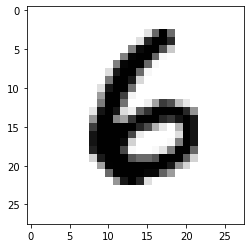

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

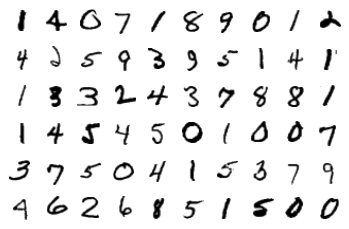

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's change the number of filtesr in the different layers.

In [8]:
dropout_value = 0.1
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.convblock1 = nn.Sequential(
        nn.Conv2d(1, 10, 3, padding=1, bias=False),
        nn.BatchNorm2d(10),
        nn.ReLU()
    ) #input 28x28x1 output 28x28x10 RF 3x3
    self.convblock2 = nn.Sequential(
        nn.Conv2d(10, 10, 3, padding=1, bias=False),
        nn.BatchNorm2d(10),
        nn.ReLU()
    ) #input 28x28x10 output 28x28x10 RF 5x5
    self.pool1 = nn.MaxPool2d(2, 2) #input 28x28x10 output 14x14x10 RF 10x10
    self.convblock3 = nn.Sequential(
        nn.Conv2d(10, 10, 3, padding=1, bias=False),
        nn.BatchNorm2d(10),
        nn.ReLU()
    ) #input 14x14x10 output 14x14x10 RF 12x12
    self.convblock4 = nn.Sequential(
        nn.Conv2d(10, 10, 3, padding=1, bias=False),
        nn.BatchNorm2d(10),
        nn.ReLU()
    ) #input 14x14x10 output 14x14x10 RF 14x14
    self.convblock5 = nn.Sequential(
        nn.Conv2d(10, 10, 3, padding=1, bias=False),
        nn.BatchNorm2d(10),
        nn.ReLU()
    ) #input 14x14x10 output 14x14x10 RF 16x16
    self.pool2 = nn.MaxPool2d(2, 2) #input 14x14x10 output 7x7x10 RF 32x32
    self.convblock6 = nn.Sequential(
        nn.Conv2d(10, 16, 3, padding =1,bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU()
    ) #input 7x7x10 output 7x7x16 RF 34x34
    self.convblock7 = nn.Sequential(
        nn.Conv2d(16, 16, 3, padding =0, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU()
    ) #input 7x7x16 output 5x5x16 RF 36x36
    
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=5)
    )#input 7x7x16 output 1x1x16 RF ?
    self.convblock8 = nn.Sequential(
        nn.Conv2d(16, 10, 1, bias=False)
    ) #input 1x1x16 output 1x1x10 RF ?

  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.pool2(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.gap(x)
    x = self.convblock8(x)
    x = x.view(-1, 10)
    return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 10, 28, 28]             900
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
         MaxPool2d-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             900
       BatchNorm2d-9           [-1, 10, 14, 14]              20
             ReLU-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 10, 14, 14]             900
      BatchNorm2d-12           [-1, 10, 14, 14]              20
             ReLU-13           [-1, 10, 14, 14]               0
           Conv2d-14           [-1

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
   
  tqdm._instances.clear()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08648469299077988 Batch_id=468 Accuracy=85.46: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0836, Accuracy: 9781/10000 (97.81%)

EPOCH: 1


Loss=0.08351734280586243 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Loss=0.06584500521421432 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9800/10000 (98.00%)

EPOCH: 3


Loss=0.0453447587788105 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.0613541342318058 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.022427350282669067 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9877/10000 (98.77%)

EPOCH: 6


Loss=0.01737215742468834 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9858/10000 (98.58%)

EPOCH: 7


Loss=0.0037669583689421415 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9825/10000 (98.25%)

EPOCH: 8


Loss=0.0117695527151227 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.026779532432556152 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9909/10000 (99.09%)

EPOCH: 10


Loss=0.002587008522823453 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 33.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9900/10000 (99.00%)

EPOCH: 11


Loss=0.053605541586875916 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9905/10000 (99.05%)

EPOCH: 12


Loss=0.008169671520590782 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9909/10000 (99.09%)

EPOCH: 13


Loss=0.02136542648077011 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9879/10000 (98.79%)

EPOCH: 14


Loss=0.039318956434726715 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]



Test set: Average loss: 0.0224, Accuracy: 9924/10000 (99.24%)



Text(0.5, 1.0, 'Test Accuracy')

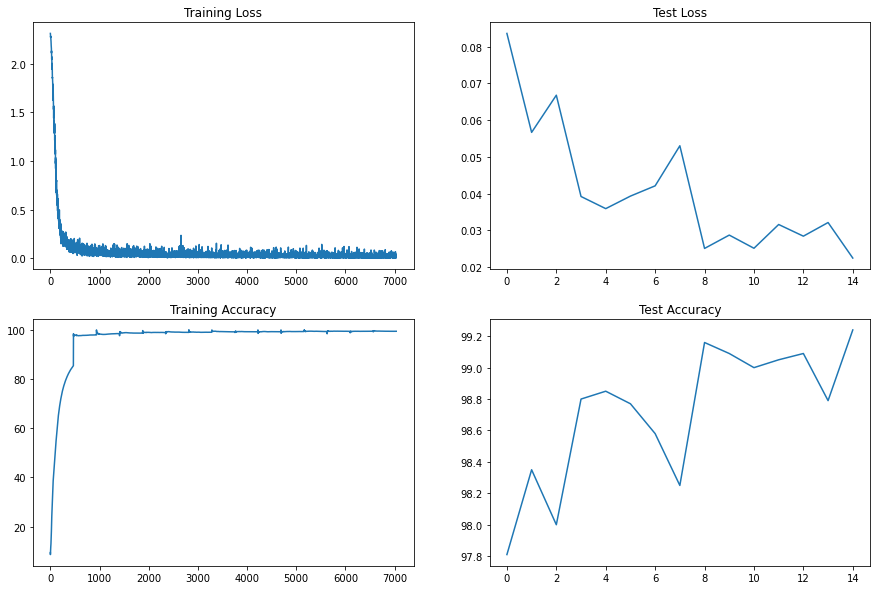

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:   
 

*   Use the structure from Step1 as the reference, and reduce the number of parameters below 10k.
*   Batch norm layers were added.


*   Use GAP instead of conv layer towards the output , reduce the number of parameters.


Result:  


*  7.758 K parameters
*   Best train accuracy = 99.47% at 13th epoch.


*   Best test accuracy = 99.24% at 14th epoch.


Analysis:


*   The number of parameters is below the required 10k parameters
*   The training accuracy has been above 99.4 % consistently for the last 3 epochs, but test accuracy has not crossed 99.4 % by the end of the 14th epoch.



